In [2]:
import numpy as np
from Utils.discrete_family import discrete_family
from Utils.barrier_affine import solve_barrier_tree, solve_barrier_tree_nonneg, solve_barrier_tree_box_PGD
from CART import RegressionTree
from scipy.interpolate import interp1d
from scipy.stats import multivariate_normal as mvn
from Utils.plotting import  *

In [3]:
# Sample data
X = np.array([[1,1.5], [2.8, 0.8], [1.2, 2.7], [3, 3]])
y = np.array([-1, 1, 5, 6])

# Create and train the regression tree
reg_tree = RegressionTree(min_samples_split=2, max_depth=3)
reg_tree.fit(X, y, sd = 3)

# Make predictions
predictions = reg_tree.predict(X)
print(predictions)

[-1.  1.  5.  6.]


In [4]:
contrast = np.array([1,1,-1,-1])
nuisance = y - np.linalg.outer(contrast,contrast) @ y / (np.linalg.norm(contrast)**2)

In [5]:
contrast = np.array([1,1,-1,-1])
np.linalg.outer(contrast,contrast)

array([[ 1,  1, -1, -1],
       [ 1,  1, -1, -1],
       [-1, -1,  1,  1],
       [-1, -1,  1,  1]])

In [6]:
contrast.T @ contrast

np.int64(4)

In [7]:
np.zeros_like([1,2,3])

array([0, 0, 0])

## Testing Approximate Reference

In [19]:
X = np.random.normal(size=(100, 5))
a = 0.5
b = 0.2
mu = b * ((X[:, 0] <= 0) * (1 + a * (X[:, 1] > 0) + (X[:, 2] * X[:, 1] <= 0)))
y = mu + np.random.normal(size=(100,), scale=1)
# Create and train the regression tree
reg_tree = RegressionTree(min_samples_split=10, max_depth=5)
reg_tree.fit(X, y, sd = 1)
sd = 1

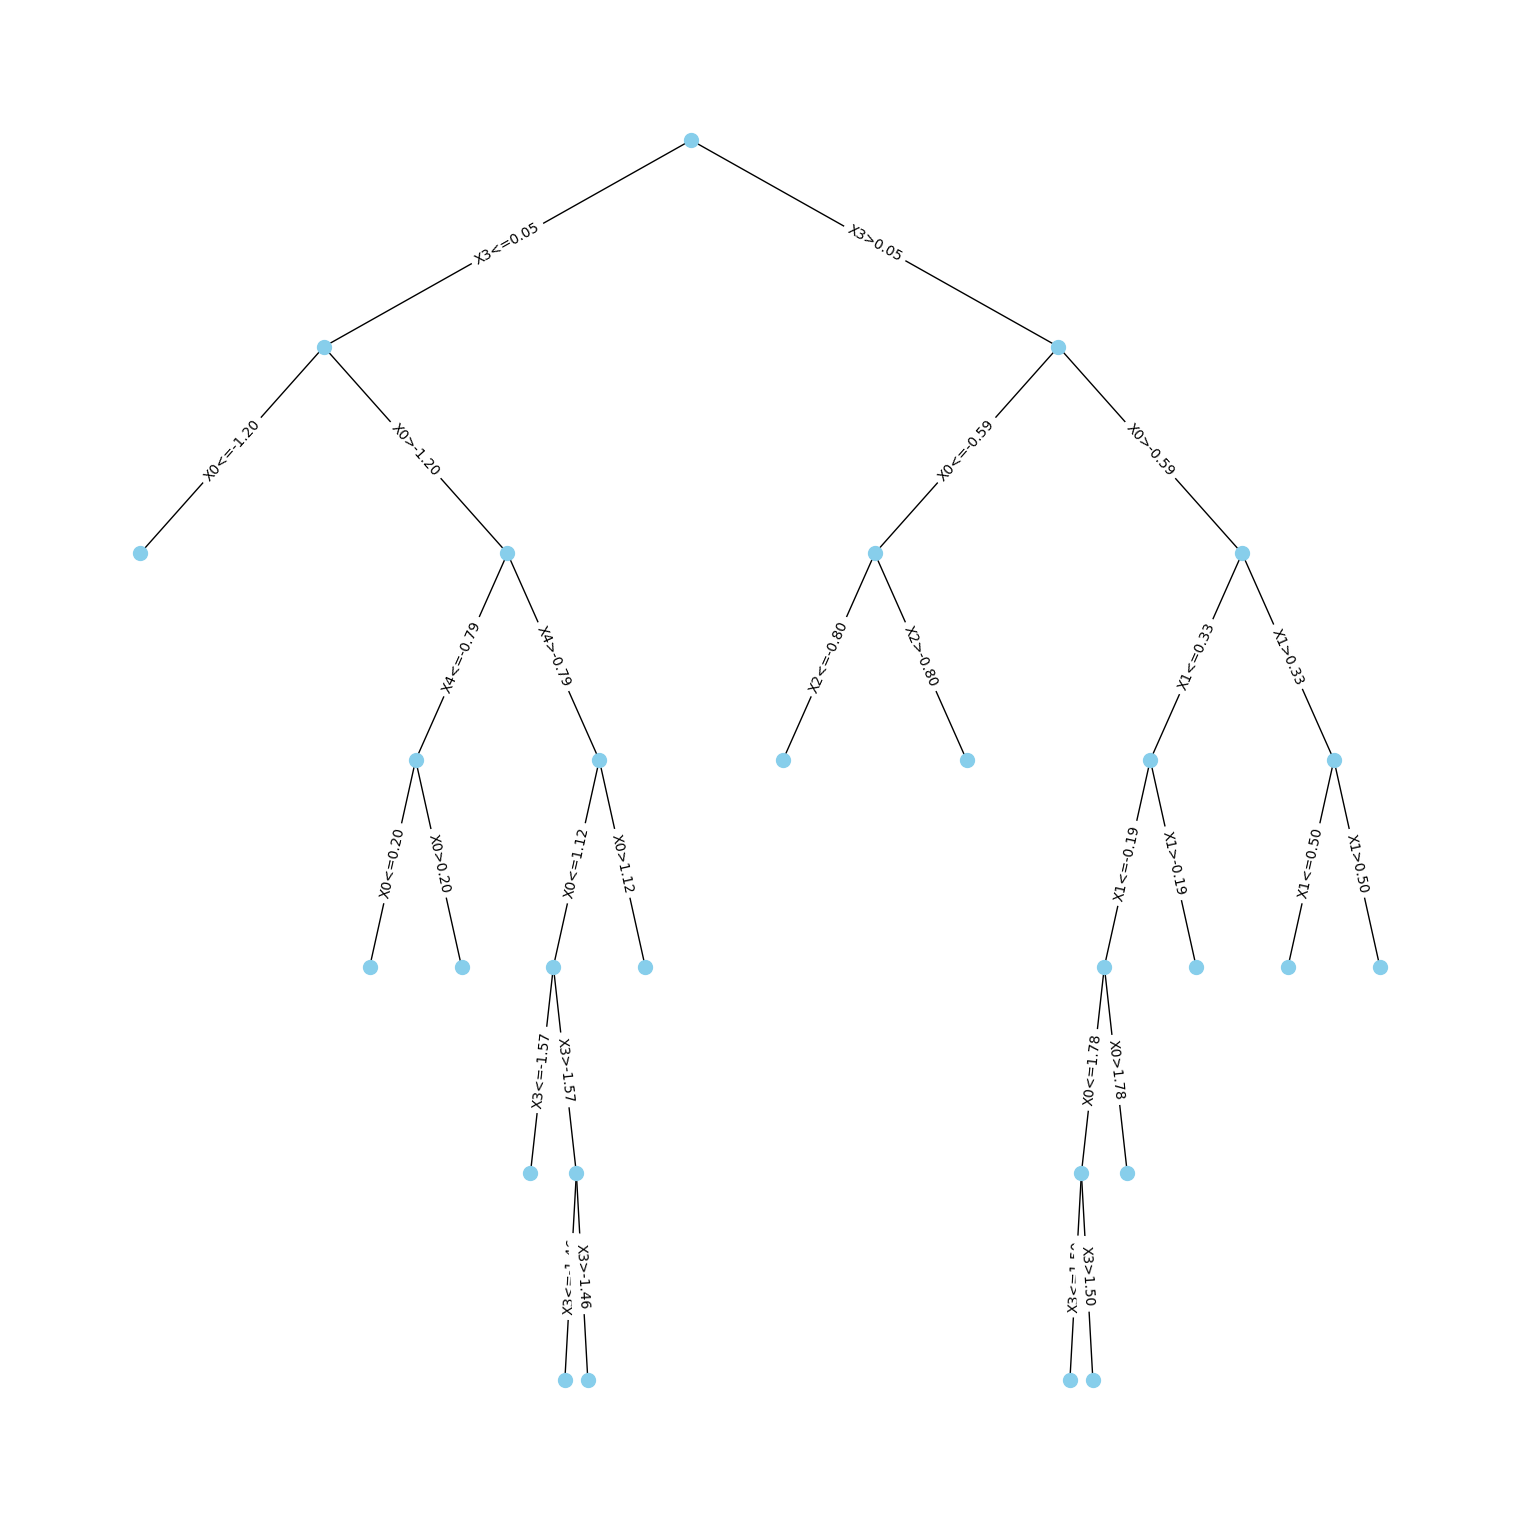

In [20]:
draw_tree(reg_tree.root)

In [60]:
pval, dist, contrast, norm_contrast, obs_tar, logW, suff, sel_probs = (
    reg_tree.condl_split_inference(node=reg_tree.root.right.right.left.left.left, 
                                   ngrid=10000,
                                   ncoarse=200,
                                   grid_width=10,
                                   reduced_dim=5))

LB: -2.297556330682265
LB: -2.297556330682265
LB: -2.297556330682265
LB: -2.297556330682265
LB: -2.297556330682265
LB: -2.297556330682265
LB: -2.297556330682265
LB: -2.297556330682265
LB: -2.297556330682265
LB: -2.297556330682265
LB: -2.297556330682265
LB: -2.297556330682265
LB: -2.297556330682265
LB: -2.297556330682265
LB: -2.297556330682265
LB: -2.297556330682265
LB: -2.297556330682265
LB: -2.297556330682265
LB: -2.297556330682265
LB: -2.297556330682265
LB: -2.297556330682265
LB: -2.297556330682265
LB: -2.297556330682265
LB: -2.297556330682265
LB: -2.297556330682265
LB: -2.297556330682265
LB: -2.297556330682265
LB: -2.297556330682265
LB: -2.297556330682265
LB: -2.297556330682265
LB: -2.297556330682265
LB: -2.297556330682265
LB: -2.297556330682265
LB: -2.297556330682265
LB: -2.297556330682265
LB: -2.297556330682265
LB: -2.297556330682265
LB: -2.297556330682265
LB: -2.297556330682265
LB: -2.297556330682265
LB: -2.297556330682265
LB: -2.297556330682265
LB: -2.297556330682265
LB: -2.2975

In [61]:
print(obs_tar)

0.562571578075847


In [62]:
print(norm_contrast.dot(mu))

-0.050636968354183326


In [63]:
mu

array([0.4, 0.2, 0. , 0. , 0.5, 0.2, 0.2, 0. , 0. , 0.2, 0.5, 0. , 0. ,
       0. , 0.3, 0.5, 0. , 0. , 0. , 0. , 0.4, 0.2, 0.5, 0. , 0. , 0. ,
       0. , 0.5, 0. , 0.4, 0.5, 0. , 0.3, 0. , 0.2, 0. , 0. , 0. , 0. ,
       0. , 0.3, 0. , 0.3, 0.5, 0. , 0.3, 0. , 0. , 0. , 0. , 0.2, 0. ,
       0. , 0.2, 0.5, 0. , 0.4, 0.4, 0. , 0. , 0.4, 0. , 0. , 0.3, 0.3,
       0. , 0.4, 0. , 0.4, 0. , 0.2, 0.5, 0. , 0.5, 0. , 0. , 0.5, 0.5,
       0. , 0.3, 0.5, 0. , 0.3, 0.4, 0.5, 0. , 0. , 0.3, 0.2, 0.3, 0.4,
       0. , 0.2, 0. , 0. , 0.2, 0.4, 0. , 0. , 0.5])

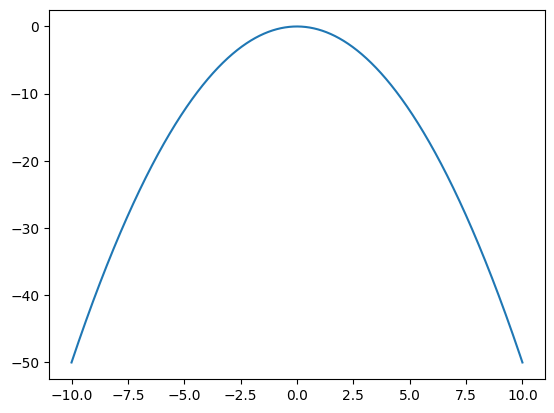

In [64]:
import matplotlib.pyplot as plt
x = np.linspace(-10, 10, 10000)
plt.plot(x, suff)

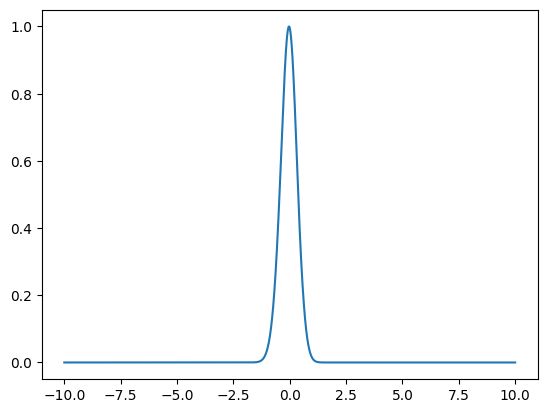

In [65]:
#plt.plot(x[380:620], sel_probs[380:620])
sel_probs -= np.max(sel_probs)
plt.plot(x, np.exp(sel_probs))

Theta setter called
Theta setter called


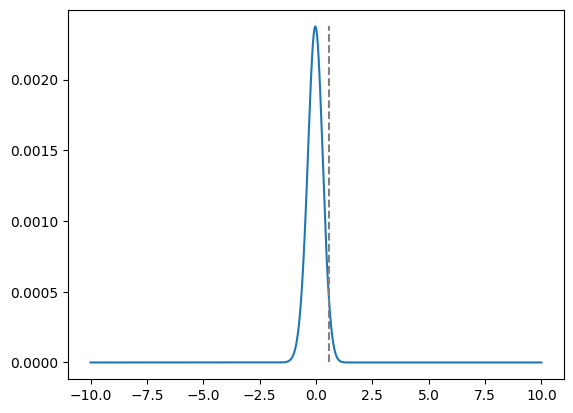

In [66]:
plt.plot(x, dist.pdf(theta=0))
plt.vlines(obs_tar, ymin=0, ymax=np.max(dist.pdf(theta=0)),
           linestyles='--', colors='grey')

In [67]:
print(dist.pdf(theta=0))

Theta setter called
[0. 0. 0. ... 0. 0. 0.]


In [68]:
pval

np.float64(0.037220293027045534)

# Replicate Tree Value Simulations

In [30]:
X = np.random.normal(size=(100, 10))
a = 1
b = 1
mu = b* ( (X[:,0] <= 0) * (1 + a * (X[:,1] > 0) + (X[:,2] * X[:,1] <= 0)) )
y = mu + np.random.normal(size=(100,), scale=1)

In [31]:
# Create and train the regression tree
reg_tree = RegressionTree(min_samples_split=10, max_depth=10)
reg_tree.fit(X, y)

# Make predictions
predictions = reg_tree.predict(X)
#print(predictions)
reg_tree.print_branches()

 j: 0
 threshold: -0.026246156794562686
 left:
	 j: 8
	 threshold: -0.47691162512272384
	 left:
		 j: 6
		 threshold: -1.882026910030391
		 left:
		 right:
			 j: 5
			 threshold: -0.7006531475942253
			 left:
			 right:
	 right:
		 j: 1
		 threshold: -0.046286560689003074
		 left:
			 j: 4
			 threshold: -0.6951223438765441
			 left:
			 right:
				 j: 1
				 threshold: -1.7342866936815915
				 left:
				 right:
					 j: 9
					 threshold: -0.2666871517794296
					 left:
					 right:
		 right:
			 j: 1
			 threshold: 1.3119538813916485
			 left:
				 j: 5
				 threshold: 0.020045901693990745
				 left:
				 right:
			 right:
 right:
	 j: 6
	 threshold: 1.1256570637586534
	 left:
		 j: 4
		 threshold: 1.461856376611065
		 left:
			 j: 6
			 threshold: -1.7952845350243212
			 left:
			 right:
				 j: 4
				 threshold: -0.4259380811250433
				 left:
					 j: 1
					 threshold: 1.6819463364634613
					 left:
						 j: 8
						 threshold: -0.3066579992144446
						 left:
						 right:
				